In [ ]:
# ==============================================================================
#                 Comprehensive Statistical Analysis Suite
# ------------------------------------------------------------------------------
# This script performs a rigorous statistical comparison of multiple algorithm
# results (BCPSO, RTS-GA versions, Random) based on a tidy data format.
# It follows a structured, budget-by-budget analysis workflow, including:
#   1. Descriptive statistics and visualization (box plots).
#   2. Overall comparison using One-way ANOVA.
#   3. Pairwise comparisons using Tukey HSD post-hoc test.
# ==============================================================================

# Install necessary libraries
%pip install openpyxl scikit-posthocs

# Core Imports
import pandas as pd
import numpy as np
import re
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

print("Setup complete. All required libraries are installed and imported.")

Setup complete. All required libraries are installed and imported.


In [ ]:
# ======================================================
# Cell 2: Step 1 - Prepare One Tidy Data File (Guided)
# ======================================================

all_runs = []
filenames_processed = []

def process_uploaded_file(uploaded_file_dict, algo_name_override=None):
    """Helper function to process a single uploaded file and append its tidy data."""
    if not uploaded_file_dict:
        print("  - No file uploaded. Skipping.")
        return None

    filename = next(iter(uploaded_file_dict))
    content = uploaded_file_dict[filename]

    print(f"  - Processing file: {filename}...")

    # Determine algorithm name
    algo_name = algo_name_override
    if algo_name is None:
        if "BCPSO" in filename: algo_name = "Baseline"
        elif "Random" in filename: algo_name = "Random"
        elif "V1_Balanced" in filename: algo_name = "Algo1"
        elif "V2_Aggressive" in filename: algo_name = "Algo2"
        elif "V3_Deep_Exploration" in filename: algo_name = "Algo3"
        elif "V4_Exhaustive" in filename: algo_name = "Algo4"
        else: algo_name = "Unknown"

    # Define which sheet to read for each algorithm type
    sheet_name_map = {
        "Baseline": "BCPSO Raw Run Data", "Random": "Raw Run Data",
        "Algo1": "RTS-GA Raw Runs", "Algo2": "RTS-GA Raw Runs",
        "Algo3": "RTS-GA Raw Runs", "Algo4": "RTS-GA Raw Runs"
    }
    df = pd.read_excel(content, sheet_name=sheet_name_map.get(algo_name))

    # Rename columns to the standard tidy format
    rename_map = {
        'Time Budget %': 'time_budget', 'budget_pct': 'time_budget',
        'Run': 'run_id', 'run': 'run_id',
        'Fully Covered BV': 'OP1_BV', 'total_business_value': 'OP1_BV',
        'Fully Covered Req %': 'OP2_reqcvg', 'req_coverage_pct': 'OP2_reqcvg'
    }
    df = df.rename(columns=rename_map)

    # --- CRITICAL FIX: Correctly calculate Req Coverage for RTS-GA files ---
    if "Algo" in algo_name:
        num_total_reqs = 248 # Project constant
        if 'num_reqs_covered' in df.columns:
            df['OP2_reqcvg'] = (df['num_reqs_covered'] / num_total_reqs) * 100
        else:
            df['OP2_reqcvg'] = 0

    df['algorithm'] = algo_name
    tidy_cols = ['time_budget', 'algorithm', 'run_id', 'OP1_BV', 'OP2_reqcvg']

    # Ensure all columns exist before returning
    for col in tidy_cols:
        if col not in df.columns: df[col] = 0

    filenames_processed.append(filename)
    print(f"  - Successfully processed as '{algo_name}'.")
    return df[tidy_cols]

# --- Guided Upload Process ---
print("\n--- Step 1 of 4: Upload Baseline (BCPSO) Report ---")
print("Please upload your 'BCPSO_Statistical_Analysis_Report.xlsx' file.")
df1 = process_uploaded_file(files.upload(), "Baseline")
if df1 is not None: all_runs.append(df1)

print("\n--- Step 2 of 4: Upload Random Selection Report ---")
print("Please upload your 'Random_Selection_Report_*.xlsx' file.")
df2 = process_uploaded_file(files.upload(), "Random")
if df2 is not None: all_runs.append(df2)

print("\n--- Step 3 of 4: Upload First GA Report (Algo1) ---")
print("Please upload the report for your first RTS-GA version (e.g., Comprehensive_Report_V2_Aggressive.xlsx).")
df3 = process_uploaded_file(files.upload(), "Algo1")
if df3 is not None: all_runs.append(df3)

print("\n--- Step 4 of 4: Upload Second GA Report (Algo2) ---")
print("Please upload the report for your second RTS-GA version (e.g., Comprehensive_Report_V3_Deep_Exploration.xlsx).")
df4 = process_uploaded_file(files.upload(), "Algo2")
if df4 is not None: all_runs.append(df4)

# --- Final Compilation ---
if all_runs:
    tidy_df = pd.concat(all_runs, ignore_index=True)

    print("\n" + "="*50); print("--- Tidy Data Compilation Complete ---")
    print(f"Total files processed: {len(filenames_processed)}")
    print(f"Total runs compiled: {len(tidy_df)}")
    print("Final columns:", tidy_df.columns.tolist())
    print("Final algorithms:", tidy_df['algorithm'].unique().tolist())

    tidy_df.to_csv("tidy_experimental_data.csv", index=False)
    print("\n'tidy_experimental_data.csv' has been created and saved.")
    print("You may now proceed to Cell 3 for analysis.")
else:
    print("\nNo data was compiled. Please re-run the cell and upload files.")


--- Step 1 of 4: Upload Baseline (BCPSO) Report ---
Please upload your 'BCPSO_Statistical_Analysis_Report.xlsx' file.


Saving BCPSO_Report.xlsx to BCPSO_Report (1).xlsx
  - Processing file: BCPSO_Report (1).xlsx...
  - Successfully processed as 'Baseline'.

--- Step 2 of 4: Upload Random Selection Report ---
Please upload your 'Random_Selection_Report_*.xlsx' file.


Saving Random_Selection_Report_defaultJS_halfsize.xlsx to Random_Selection_Report_defaultJS_halfsize (1).xlsx
  - Processing file: Random_Selection_Report_defaultJS_halfsize (1).xlsx...
  - Successfully processed as 'Random'.

--- Step 3 of 4: Upload First GA Report (Algo1) ---
Please upload the report for your first RTS-GA version (e.g., Comprehensive_Report_V2_Aggressive.xlsx).


Saving RTS-GA-v1-balanced.xlsx to RTS-GA-v1-balanced.xlsx
  - Processing file: RTS-GA-v1-balanced.xlsx...
  - Successfully processed as 'Algo1'.

--- Step 4 of 4: Upload Second GA Report (Algo2) ---
Please upload the report for your second RTS-GA version (e.g., Comprehensive_Report_V3_Deep_Exploration.xlsx).


Saving RTS-GA-v1_balanced_v3.xlsx to RTS-GA-v1_balanced_v3 (1).xlsx
  - Processing file: RTS-GA-v1_balanced_v3 (1).xlsx...
  - Successfully processed as 'Algo2'.

--- Tidy Data Compilation Complete ---
Total files processed: 4
Total runs compiled: 2280
Final columns: ['time_budget', 'algorithm', 'run_id', 'OP1_BV', 'OP2_reqcvg']
Final algorithms: ['Baseline', 'Random', 'Algo1', 'Algo2']

'tidy_experimental_data.csv' has been created and saved.
You may now proceed to Cell 3 for analysis.



ANALYSIS FOR: Time Budget = 5%, Output = Business Value


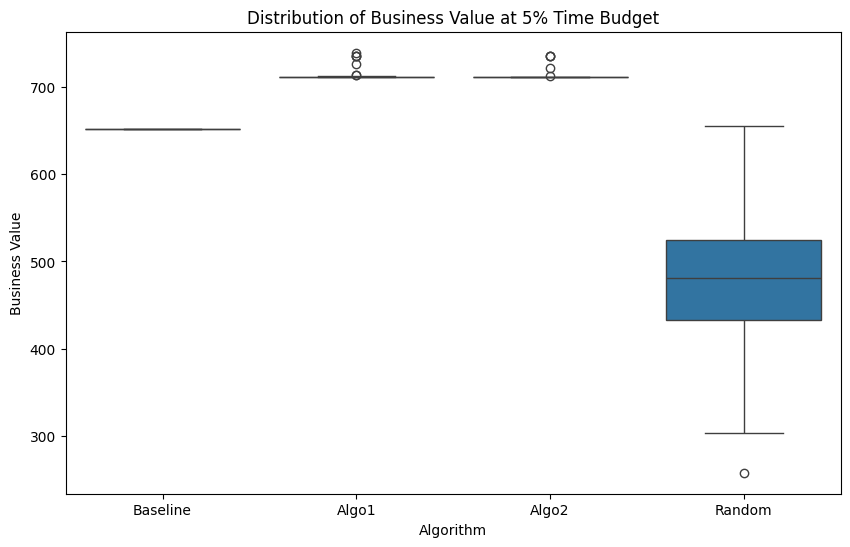


--- Descriptive Statistics ---
                 mean        std
algorithm                       
Baseline   652.000000   0.000000
Algo1      715.033333   8.833648
Algo2      713.766667   7.426343
Random     481.533333  87.283025

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 187.4517
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline  -63.0333   [-92.6614, -33.4053]  0.0000          Yes
  Algo1 vs Random -233.5000 [-263.1280, -203.8720]  0.0000          Yes
Algo2 vs Baseline  -61.7667   [-91.3947, -32.1386]  0.0000          Yes
  Algo2 vs Random -232.2333 [-261.8614, -202.6053]  0.0000          Yes
   Algo1 vs Algo2   -1.2667    [-30.8947, 28.3614]  0.9995           No

ANALYSIS FOR: Time Budget = 5%, Output = Requirements Coverage


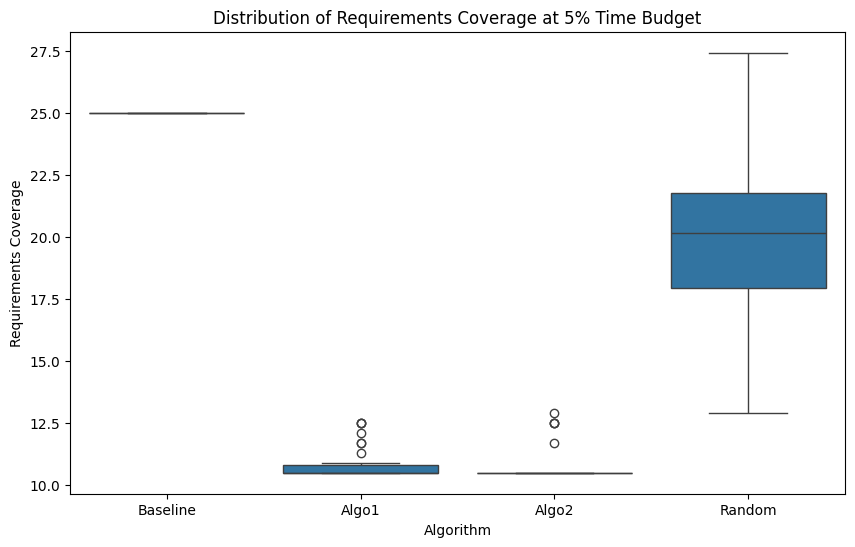


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   25.000000  0.000000
Algo1      10.860215  0.701878
Algo2      10.806452  0.751761
Random     19.731183  3.251658

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 505.1121
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +14.1398 [12.9921, 15.2875]  0.0000          Yes
  Algo1 vs Random   +8.8710  [7.7233, 10.0186]  0.0000          Yes
Algo2 vs Baseline  +14.1935 [13.0459, 15.3412]  0.0000          Yes
  Algo2 vs Random   +8.9247  [7.7771, 10.0724]  0.0000          Yes
   Algo1 vs Algo2   -0.0538  [-1.2014, 1.0939]  0.9993           No

ANALYSIS FOR: Time Budget = 10%, Output = Business Value


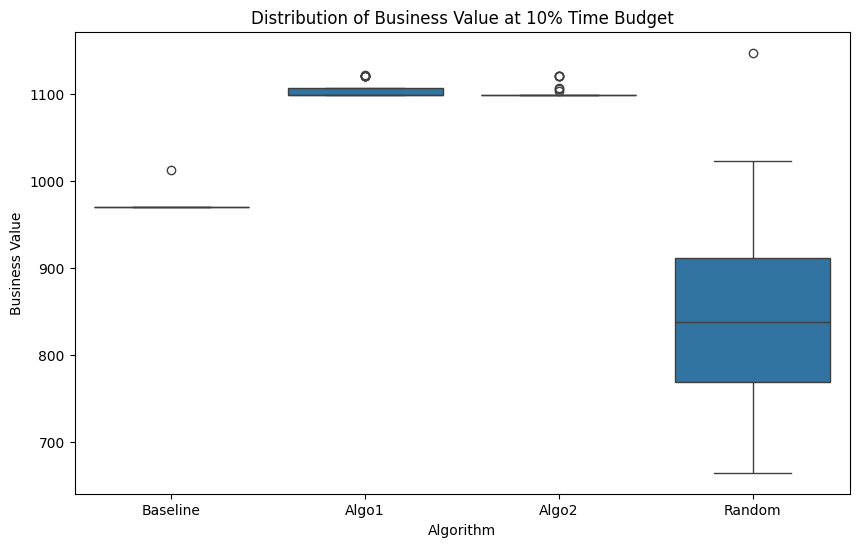


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline    971.400000    7.668116
Algo1      1103.966667    9.331014
Algo2      1101.666667    7.630851
Random      845.233333  113.159541

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 140.7988
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline -132.5667  [-170.9493, -94.1841]  0.0000          Yes
  Algo1 vs Random -258.7333 [-297.1159, -220.3507]  0.0000          Yes
Algo2 vs Baseline -130.2667  [-168.6493, -91.8841]  0.0000          Yes
  Algo2 vs Random -256.4333 [-294.8159, -218.0507]  0.0000          Yes
   Algo1 vs Algo2   -2.3000    [-40.6826, 36.0826]  0.9986           No

ANALYSIS FOR: Time Budget = 10%, Output = Requirements Coverage


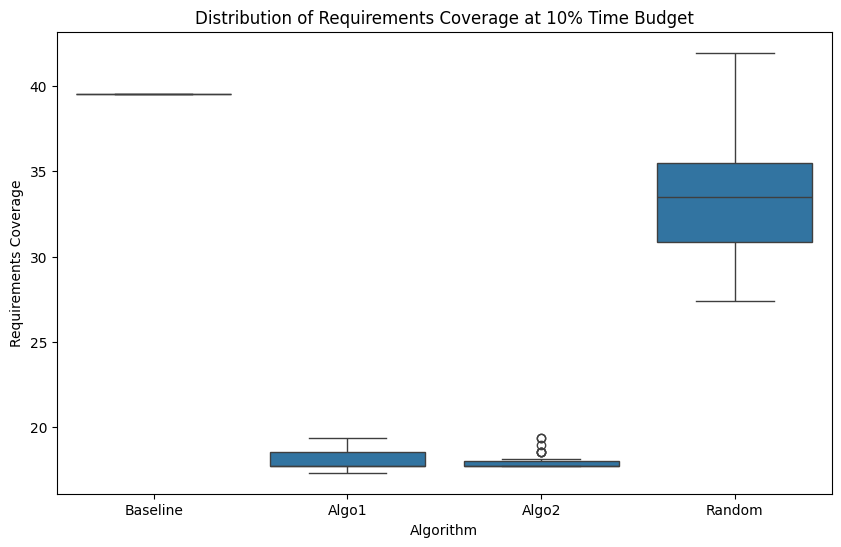


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   39.516129  0.000000
Algo1      18.051075  0.493091
Algo2      18.010753  0.500427
Random     33.252688  3.439028

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 1157.3153
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +21.4651 [20.2839, 22.6463]  0.0000          Yes
  Algo1 vs Random  +15.2016 [14.0204, 16.3828]  0.0000          Yes
Algo2 vs Baseline  +21.5054 [20.3242, 22.6866]  0.0000          Yes
  Algo2 vs Random  +15.2419 [14.0607, 16.4231]  0.0000          Yes
   Algo1 vs Algo2   -0.0403  [-1.2215, 1.1409]  0.9997           No

ANALYSIS FOR: Time Budget = 15%, Output = Business Value


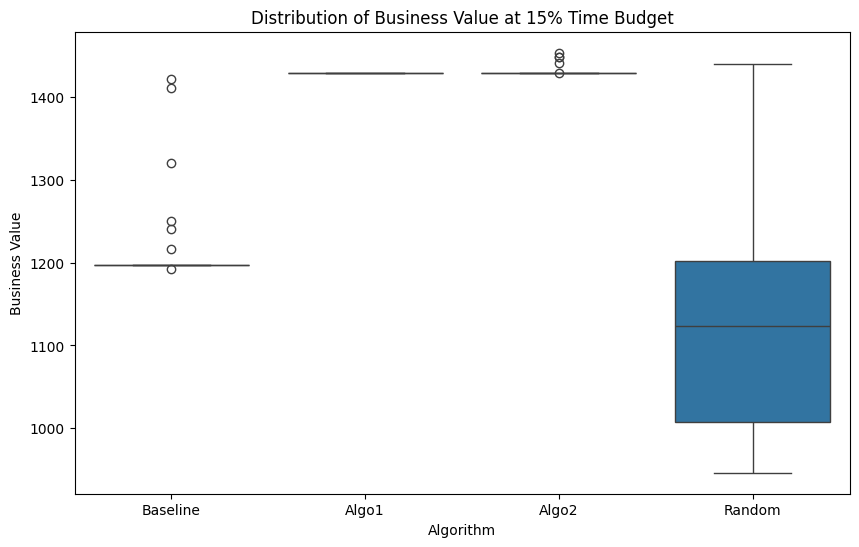


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1219.533333   59.260229
Algo1      1429.000000    0.000000
Algo2      1431.633333    6.915666
Random     1119.000000  113.651312

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 177.7205
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline -209.4667 [-252.6622, -166.2712]  0.0000          Yes
  Algo1 vs Random -310.0000 [-353.1955, -266.8045]  0.0000          Yes
Algo2 vs Baseline -212.1000 [-255.2955, -168.9045]  0.0000          Yes
  Algo2 vs Random -312.6333 [-355.8288, -269.4378]  0.0000          Yes
   Algo1 vs Algo2   +2.6333    [-40.5622, 45.8288]  0.9986           No

ANALYSIS FOR: Time Budget = 15%, Output = Requirements Coverage


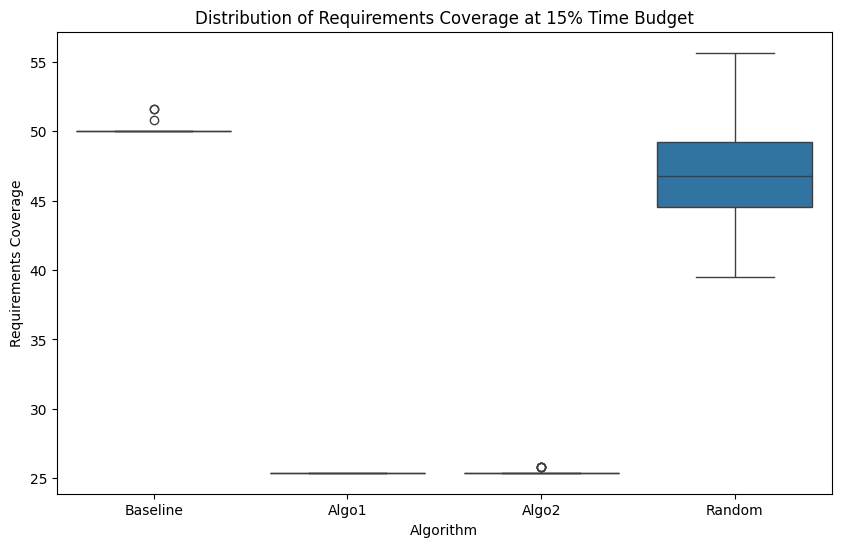


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   50.134409  0.427959
Algo1      25.403226  0.000000
Algo2      25.470430  0.152842
Random     46.801075  3.559514

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 1664.9697
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +24.7312 [23.5236, 25.9387]  0.0000          Yes
  Algo1 vs Random  +21.3978 [20.1903, 22.6054]  0.0000          Yes
Algo2 vs Baseline  +24.6640 [23.4564, 25.8715]  0.0000          Yes
  Algo2 vs Random  +21.3306 [20.1231, 22.5382]  0.0000          Yes
   Algo1 vs Algo2   +0.0672  [-1.1404, 1.2748]  0.9989           No

ANALYSIS FOR: Time Budget = 20%, Output = Business Value


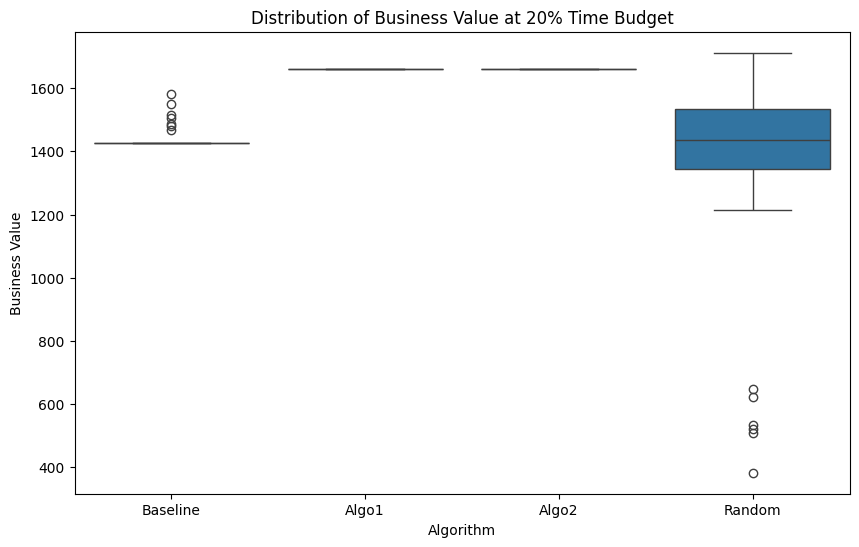


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1446.200000   41.606863
Algo1      1659.000000    0.000000
Algo2      1659.000000    0.000000
Random     1287.966667  396.949965

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 24.5409
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline -212.8000  [-347.1130, -78.4870]  0.0004          Yes
  Algo1 vs Random -371.0333 [-505.3463, -236.7203]  0.0000          Yes
Algo2 vs Baseline -212.8000  [-347.1130, -78.4870]  0.0004          Yes
  Algo2 vs Random -371.0333 [-505.3463, -236.7203]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-134.3130, 134.3130]  1.0000           No

ANALYSIS FOR: Time Budget = 20%, Output = Requirements Coverage


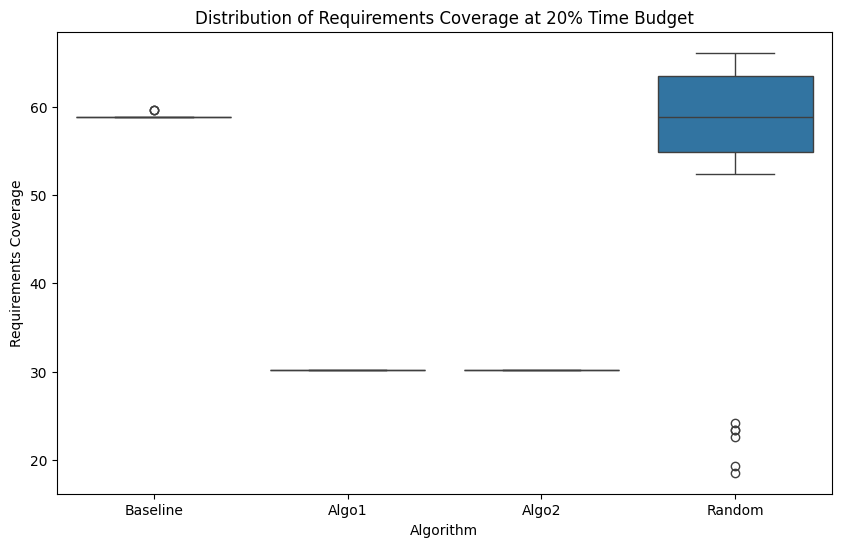


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   58.951613   0.246071
Algo1      30.241935   0.000000
Algo2      30.241935   0.000000
Random     52.688172  16.080758

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 104.2094
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +28.7097 [23.2976, 34.1218]  0.0000          Yes
  Algo1 vs Random  +22.4462 [17.0341, 27.8584]  0.0000          Yes
Algo2 vs Baseline  +28.7097 [23.2976, 34.1218]  0.0000          Yes
  Algo2 vs Random  +22.4462 [17.0341, 27.8584]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-5.4121, 5.4121]  1.0000           No

ANALYSIS FOR: Time Budget = 25%, Output = Business Value


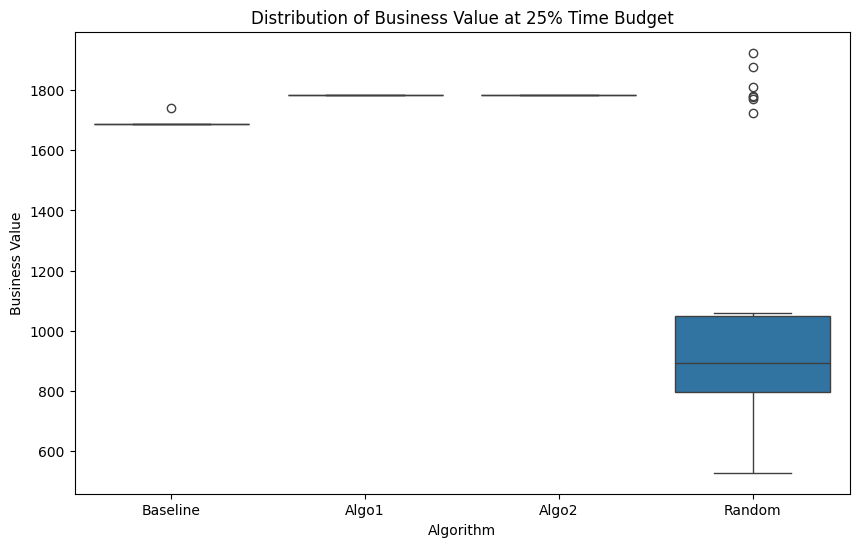


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1690.733333    9.493858
Algo1      1785.000000    0.000000
Algo2      1785.000000    0.000000
Random     1062.533333  435.625411

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 76.7053
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline  -94.2667   [-240.8977, 52.3644]  0.3411           No
  Algo1 vs Random -722.4667 [-869.0977, -575.8356]  0.0000          Yes
Algo2 vs Baseline  -94.2667   [-240.8977, 52.3644]  0.3411           No
  Algo2 vs Random -722.4667 [-869.0977, -575.8356]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-146.6310, 146.6310]  1.0000           No

ANALYSIS FOR: Time Budget = 25%, Output = Requirements Coverage


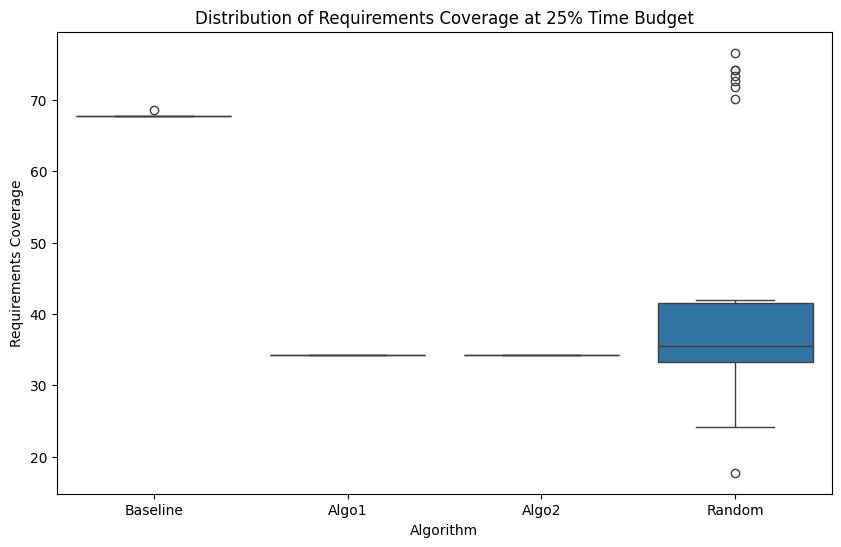


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   67.768817   0.147237
Algo1      34.274194   0.000000
Algo2      34.274194   0.000000
Random     42.930108  17.698505

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 96.1056
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +33.4946 [27.5385, 39.4507]  0.0000          Yes
  Algo1 vs Random   +8.6559  [2.6998, 14.6120]  0.0014          Yes
Algo2 vs Baseline  +33.4946 [27.5385, 39.4507]  0.0000          Yes
  Algo2 vs Random   +8.6559  [2.6998, 14.6120]  0.0014          Yes
   Algo1 vs Algo2   +0.0000  [-5.9561, 5.9561]  1.0000           No

ANALYSIS FOR: Time Budget = 30%, Output = Business Value


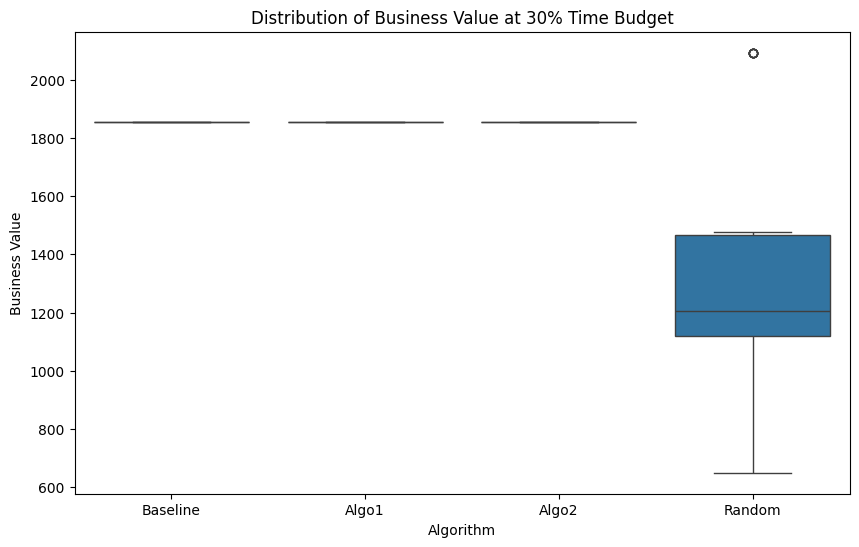


--- Descriptive Statistics ---
             mean         std
algorithm                    
Baseline   1853.0    0.000000
Algo1      1853.0    0.000000
Algo2      1853.0    0.000000
Random     1371.5  437.059591

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 36.4110
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline   +0.0000  [-147.0789, 147.0789]  1.0000           No
  Algo1 vs Random -481.5000 [-628.5789, -334.4211]  0.0000          Yes
Algo2 vs Baseline   +0.0000  [-147.0789, 147.0789]  1.0000           No
  Algo2 vs Random -481.5000 [-628.5789, -334.4211]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-147.0789, 147.0789]  1.0000           No

ANALYSIS FOR: Time Budget = 30%, Output = Requirements Coverage


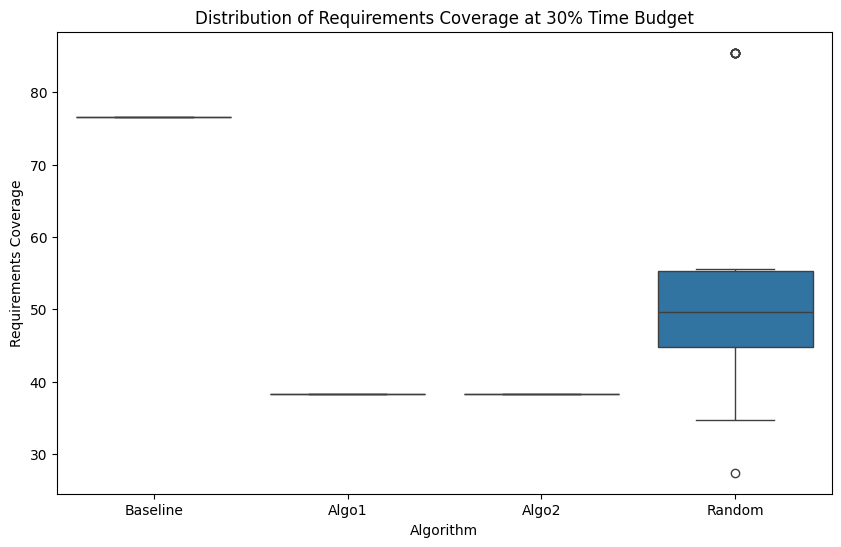


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   76.612903   0.000000
Algo1      38.306452   0.000000
Algo2      38.306452   0.000000
Random     55.376344  18.035708

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 122.0007
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +38.3065 [32.2371, 44.3758]  0.0000          Yes
  Algo1 vs Random  +17.0699 [11.0005, 23.1393]  0.0000          Yes
Algo2 vs Baseline  +38.3065 [32.2371, 44.3758]  0.0000          Yes
  Algo2 vs Random  +17.0699 [11.0005, 23.1393]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-6.0694, 6.0694]  1.0000           No

ANALYSIS FOR: Time Budget = 35%, Output = Business Value


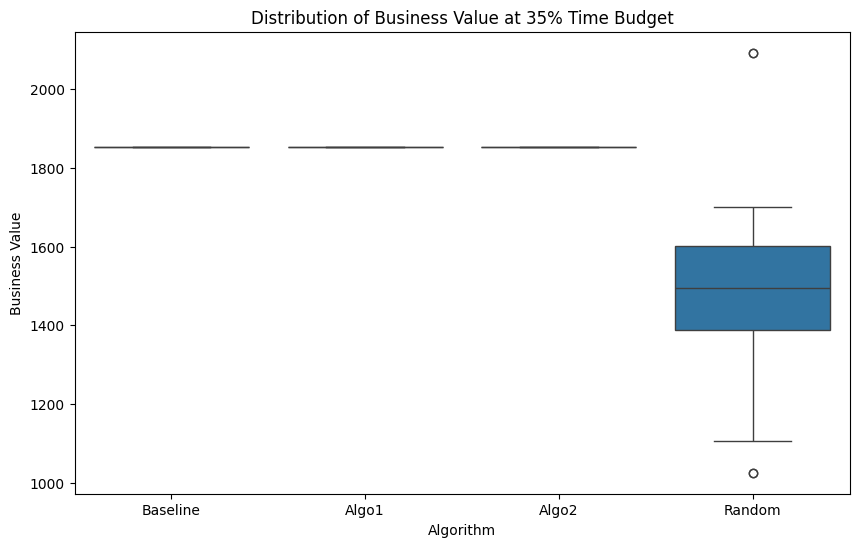


--- Descriptive Statistics ---
             mean         std
algorithm                    
Baseline   1853.0    0.000000
Algo1      1853.0    0.000000
Algo2      1853.0    0.000000
Random     1487.0  237.961602

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 70.9692
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline   +0.0000    [-80.0786, 80.0786]  1.0000           No
  Algo1 vs Random -366.0000 [-446.0786, -285.9214]  0.0000          Yes
Algo2 vs Baseline   +0.0000    [-80.0786, 80.0786]  1.0000           No
  Algo2 vs Random -366.0000 [-446.0786, -285.9214]  0.0000          Yes
   Algo1 vs Algo2   +0.0000    [-80.0786, 80.0786]  1.0000           No

ANALYSIS FOR: Time Budget = 35%, Output = Requirements Coverage


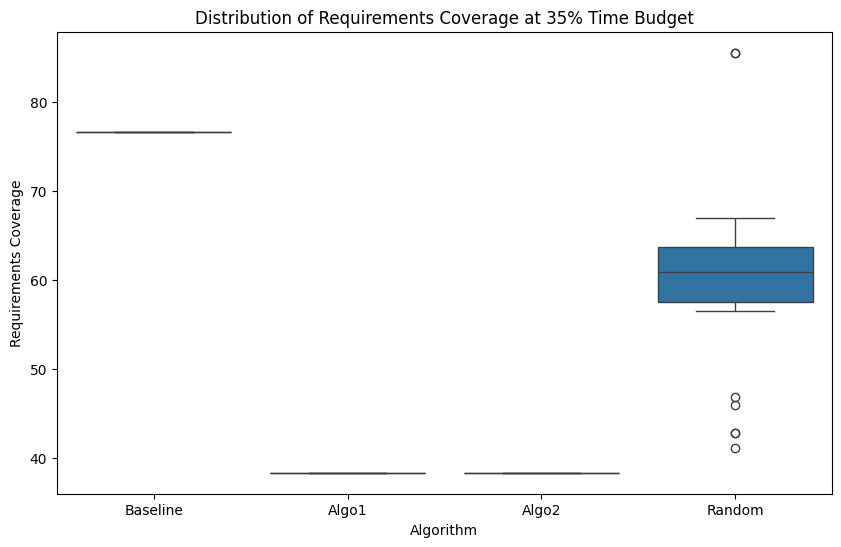


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   76.612903  0.000000
Algo1      38.306452  0.000000
Algo2      38.306452  0.000000
Random     60.161290  9.973232

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 418.3056
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +38.3065 [34.9503, 41.6626]  0.0000          Yes
  Algo1 vs Random  +21.8548 [18.4987, 25.2110]  0.0000          Yes
Algo2 vs Baseline  +38.3065 [34.9503, 41.6626]  0.0000          Yes
  Algo2 vs Random  +21.8548 [18.4987, 25.2110]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-3.3562, 3.3562]  1.0000           No

ANALYSIS FOR: Time Budget = 40%, Output = Business Value


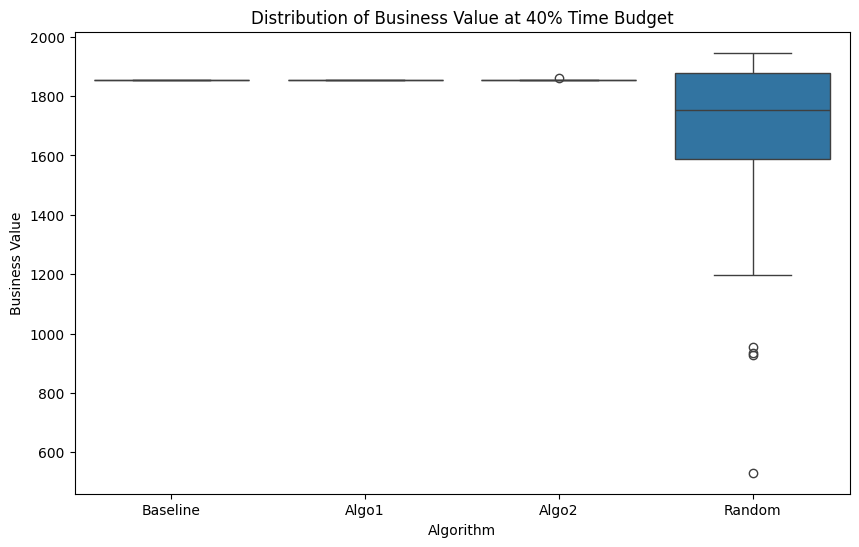


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1853.000000    0.000000
Algo1      1853.000000    0.000000
Algo2      1853.266667    1.460593
Random     1640.866667  363.029184

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 10.2521
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline   +0.0000 [-122.1672, 122.1672]  1.0000           No
  Algo1 vs Random -212.1333 [-334.3005, -89.9661]  0.0001          Yes
Algo2 vs Baseline   -0.2667 [-122.4339, 121.9005]  1.0000           No
  Algo2 vs Random -212.4000 [-334.5672, -90.2328]  0.0001          Yes
   Algo1 vs Algo2   +0.2667 [-121.9005, 122.4339]  1.0000           No

ANALYSIS FOR: Time Budget = 40%, Output = Requirements Coverage


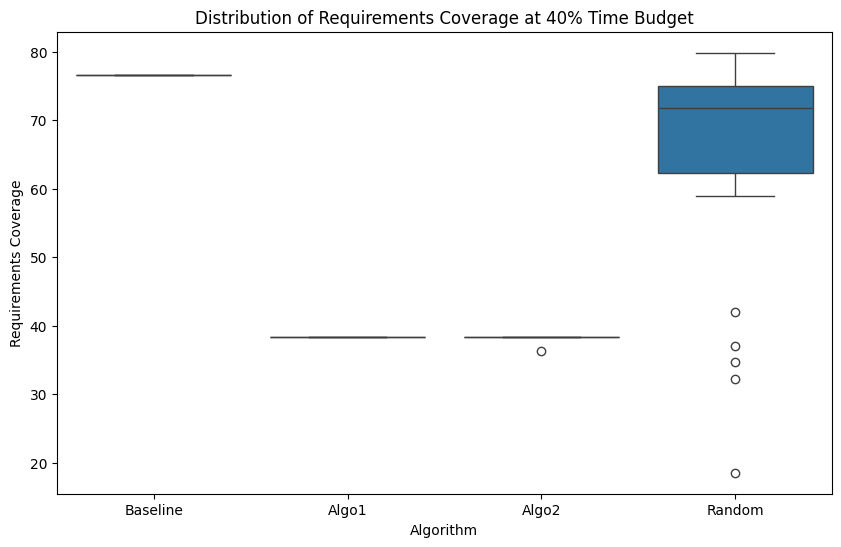


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   76.612903   0.000000
Algo1      38.306452   0.000000
Algo2      38.239247   0.368093
Random     65.000000  15.864912

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 178.8291
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +38.3065 [32.9662, 43.6467]  0.0000          Yes
  Algo1 vs Random  +26.6935 [21.3533, 32.0338]  0.0000          Yes
Algo2 vs Baseline  +38.3737 [33.0334, 43.7139]  0.0000          Yes
  Algo2 vs Random  +26.7608 [21.4205, 32.1010]  0.0000          Yes
   Algo1 vs Algo2   -0.0672  [-5.4075, 5.2731]  1.0000           No

ANALYSIS FOR: Time Budget = 45%, Output = Business Value


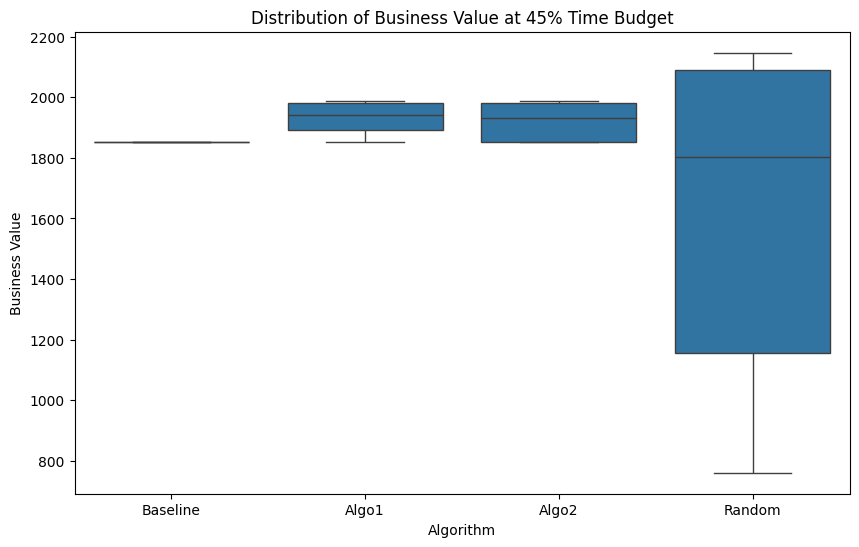


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1853.000000    0.000000
Algo1      1933.566667   51.539528
Algo2      1919.400000   60.950856
Random     1618.633333  474.571493

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 11.0399
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline  -80.5667   [-242.5122, 81.3789]  0.5668           No
  Algo1 vs Random -314.9333 [-476.8789, -152.9878]  0.0000          Yes
Algo2 vs Baseline  -66.4000   [-228.3455, 95.5455]  0.7092           No
  Algo2 vs Random -300.7667 [-462.7122, -138.8211]  0.0000          Yes
   Algo1 vs Algo2  -14.1667  [-176.1122, 147.7789]  0.9958           No

ANALYSIS FOR: Time Budget = 45%, Output = Requirements Coverage


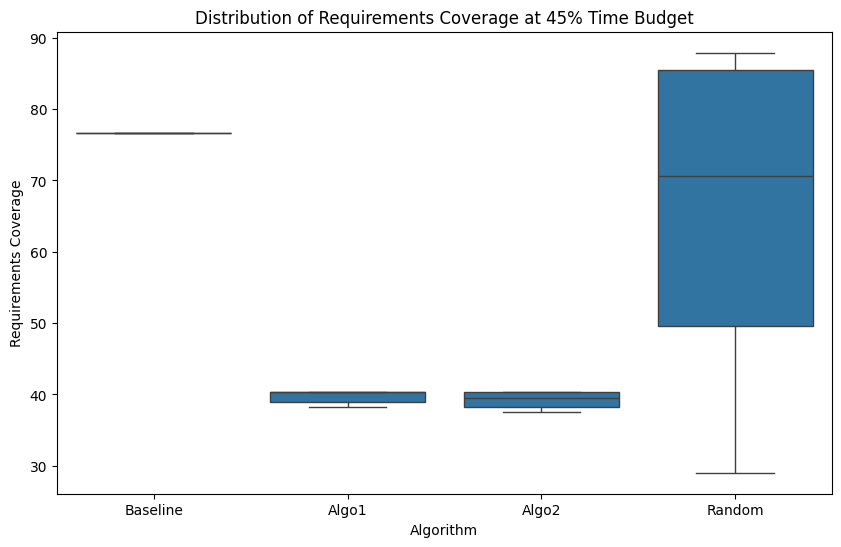


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   76.612903   0.000000
Algo1      39.677419   0.831103
Algo2      39.327957   0.991851
Random     65.698925  18.574042

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 122.4850
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +36.9355 [30.6698, 43.2012]  0.0000          Yes
  Algo1 vs Random  +26.0215 [19.7558, 32.2872]  0.0000          Yes
Algo2 vs Baseline  +37.2849 [31.0193, 43.5506]  0.0000          Yes
  Algo2 vs Random  +26.3710 [20.1053, 32.6366]  0.0000          Yes
   Algo1 vs Algo2   -0.3495  [-6.6151, 5.9162]  0.9989           No

ANALYSIS FOR: Time Budget = 50%, Output = Business Value


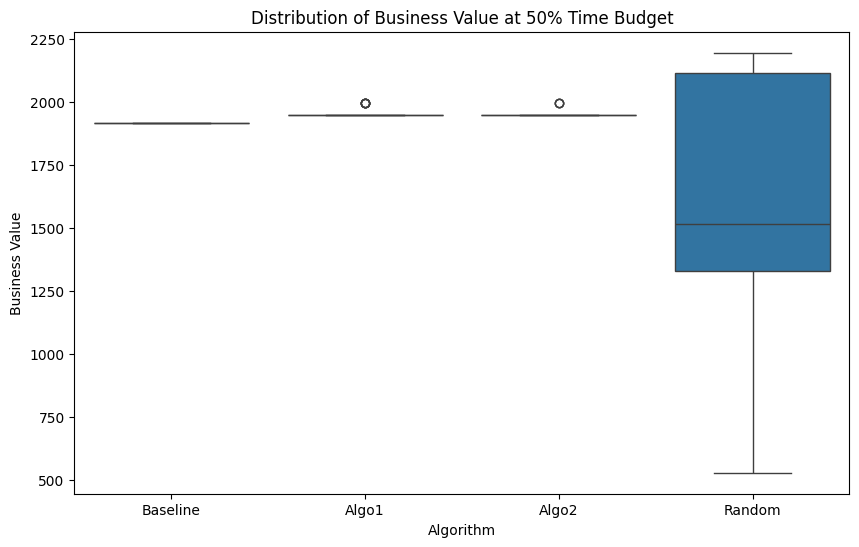


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1916.000000    0.000000
Algo1      1956.400000   19.121391
Algo2      1951.700000   14.341043
Random     1597.633333  432.858779

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 19.0681
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline  -40.4000  [-186.2871, 105.4871]  0.8882           No
  Algo1 vs Random -358.7667 [-504.6538, -212.8796]  0.0000          Yes
Algo2 vs Baseline  -35.7000  [-181.5871, 110.1871]  0.9195           No
  Algo2 vs Random -354.0667 [-499.9538, -208.1796]  0.0000          Yes
   Algo1 vs Algo2   -4.7000  [-150.5871, 141.1871]  0.9998           No

ANALYSIS FOR: Time Budget = 50%, Output = Requirements Coverage


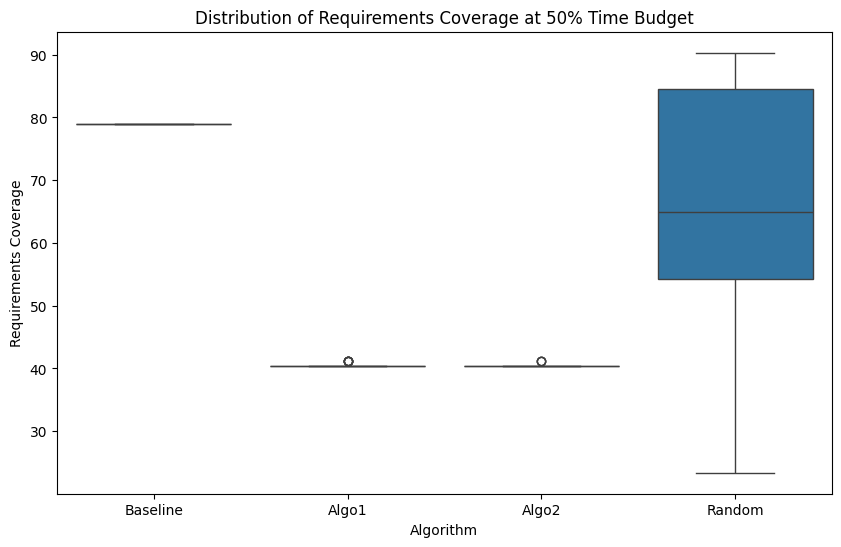


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   79.032258   0.000000
Algo1      40.483871   0.328095
Algo2      40.403226   0.246071
Random     65.376344  17.521808

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 143.4968
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +38.5484 [32.6504, 44.4464]  0.0000          Yes
  Algo1 vs Random  +24.8925 [18.9944, 30.7905]  0.0000          Yes
Algo2 vs Baseline  +38.6290 [32.7310, 44.5271]  0.0000          Yes
  Algo2 vs Random  +24.9731 [19.0751, 30.8712]  0.0000          Yes
   Algo1 vs Algo2   -0.0806  [-5.9787, 5.8174]  1.0000           No

ANALYSIS FOR: Time Budget = 55%, Output = Business Value


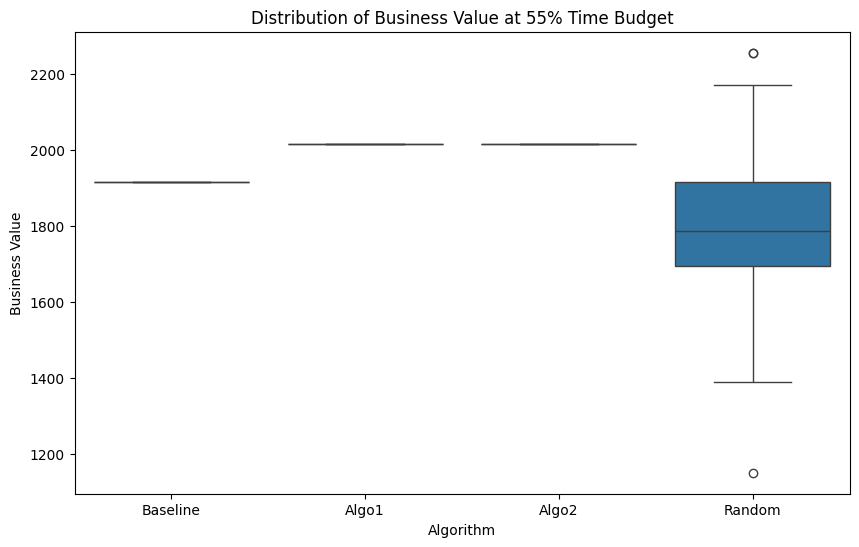


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1916.000000    0.000000
Algo1      2016.000000    0.000000
Algo2      2016.000000    0.000000
Random     1780.166667  238.414169

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 26.3339
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline -100.0000  [-180.2309, -19.7691]  0.0081          Yes
  Algo1 vs Random -235.8333 [-316.0642, -155.6024]  0.0000          Yes
Algo2 vs Baseline -100.0000  [-180.2309, -19.7691]  0.0081          Yes
  Algo2 vs Random -235.8333 [-316.0642, -155.6024]  0.0000          Yes
   Algo1 vs Algo2   +0.0000    [-80.2309, 80.2309]  1.0000           No

ANALYSIS FOR: Time Budget = 55%, Output = Requirements Coverage


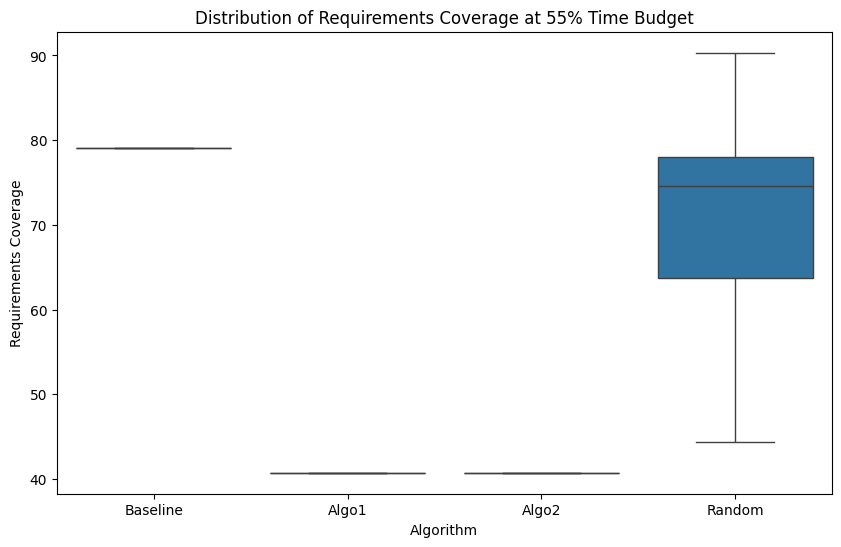


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   79.032258   0.000000
Algo1      40.725806   0.000000
Algo2      40.725806   0.000000
Random     71.774194  10.709265

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 428.5921
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +38.3065 [34.7026, 41.9103]  0.0000          Yes
  Algo1 vs Random  +31.0484 [27.4445, 34.6523]  0.0000          Yes
Algo2 vs Baseline  +38.3065 [34.7026, 41.9103]  0.0000          Yes
  Algo2 vs Random  +31.0484 [27.4445, 34.6523]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-3.6039, 3.6039]  1.0000           No

ANALYSIS FOR: Time Budget = 60%, Output = Business Value


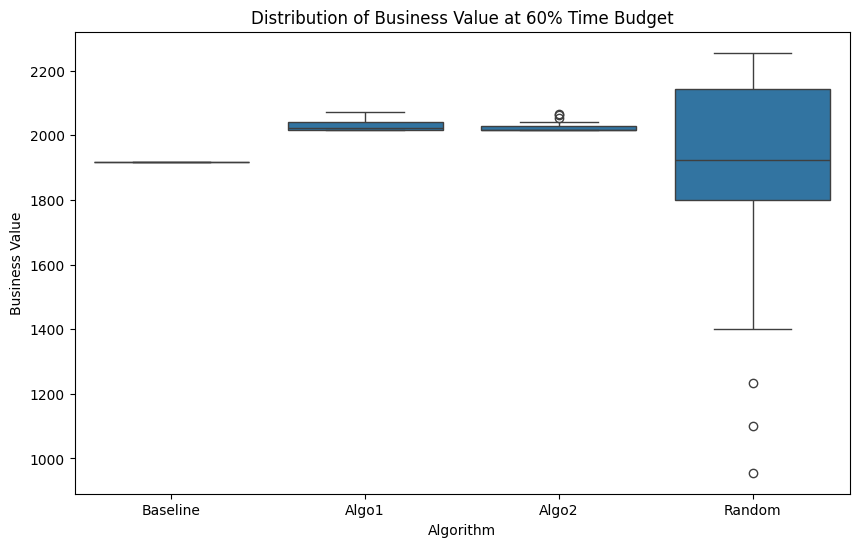


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   1916.000000    0.000000
Algo1      2029.966667   17.147400
Algo2      2025.000000   14.190818
Random     1884.333333  333.838525

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 5.9756
p-value: 0.0008

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline -113.9667  [-226.5591, -1.3742]  0.0461          Yes
  Algo1 vs Random -145.6333 [-258.2258, -33.0409]  0.0055          Yes
Algo2 vs Baseline -109.0000   [-221.5924, 3.5924]  0.0615           No
  Algo2 vs Random -140.6667 [-253.2591, -28.0742]  0.0080          Yes
   Algo1 vs Algo2   -4.9667 [-117.5591, 107.6258]  0.9995           No

ANALYSIS FOR: Time Budget = 60%, Output = Requirements Coverage


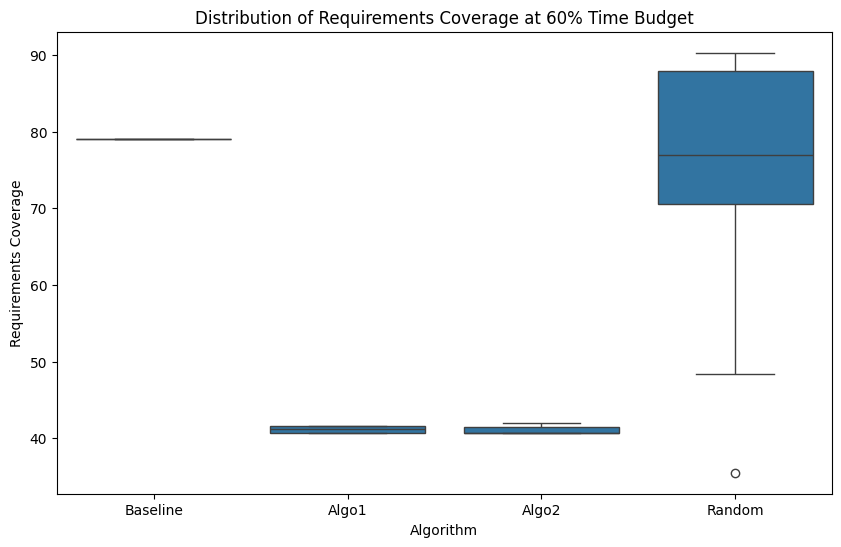


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   79.032258   0.000000
Algo1      41.115591   0.358838
Algo2      41.008065   0.412165
Random     76.532258  14.019995

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 274.6172
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +37.9167 [33.1951, 42.6382]  0.0000          Yes
  Algo1 vs Random  +35.4167 [30.6951, 40.1382]  0.0000          Yes
Algo2 vs Baseline  +38.0242 [33.3026, 42.7458]  0.0000          Yes
  Algo2 vs Random  +35.5242 [30.8026, 40.2458]  0.0000          Yes
   Algo1 vs Algo2   -0.1075  [-4.8291, 4.6141]  0.9999           No

ANALYSIS FOR: Time Budget = 65%, Output = Business Value


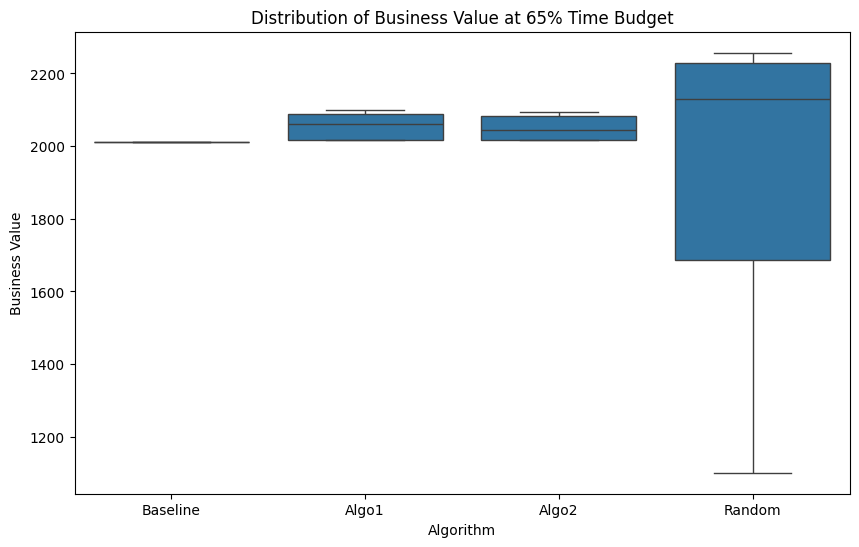


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   2010.000000    0.000000
Algo1      2053.200000   34.248987
Algo2      2049.933333   31.470767
Random     1944.633333  363.908049

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 2.2750
p-value: 0.0836

Result: No significant difference among algorithms.

ANALYSIS FOR: Time Budget = 65%, Output = Requirements Coverage


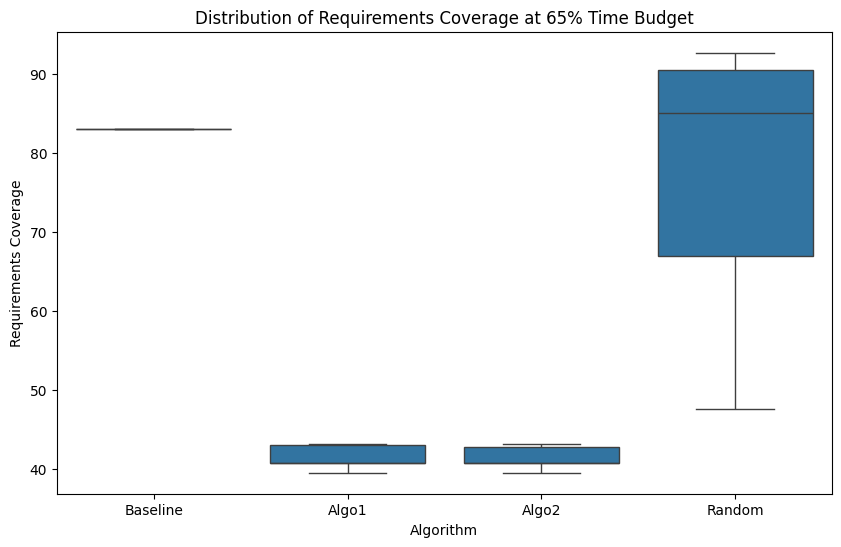


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   83.064516   0.000000
Algo1      41.451613   1.259183
Algo2      41.370968   1.268941
Random     78.709677  14.678367

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 286.8188
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +41.6129 [36.6369, 46.5890]  0.0000          Yes
  Algo1 vs Random  +37.2581 [32.2820, 42.2341]  0.0000          Yes
Algo2 vs Baseline  +41.6935 [36.7175, 46.6696]  0.0000          Yes
  Algo2 vs Random  +37.3387 [32.3627, 42.3148]  0.0000          Yes
   Algo1 vs Algo2   -0.0806  [-5.0567, 4.8954]  1.0000           No

ANALYSIS FOR: Time Budget = 70%, Output = Business Value


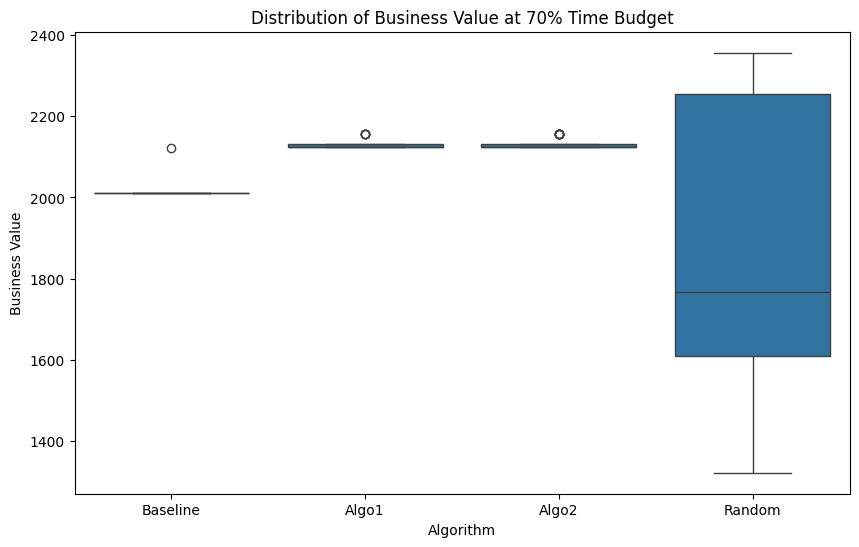


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   2013.700000   20.265735
Algo1      2130.266667   10.897432
Algo2      2133.666667   13.301110
Random     1876.333333  363.716670

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 13.3510
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                 95% CI p-value Significant?
Algo1 vs Baseline -116.5667    [-239.2906, 6.1572]  0.0691           No
  Algo1 vs Random -253.9333 [-376.6572, -131.2094]  0.0000          Yes
Algo2 vs Baseline -119.9667    [-242.6906, 2.7572]  0.0579           No
  Algo2 vs Random -257.3333 [-380.0572, -134.6094]  0.0000          Yes
   Algo1 vs Algo2   +3.4000  [-119.3239, 126.1239]  0.9999           No

ANALYSIS FOR: Time Budget = 70%, Output = Requirements Coverage


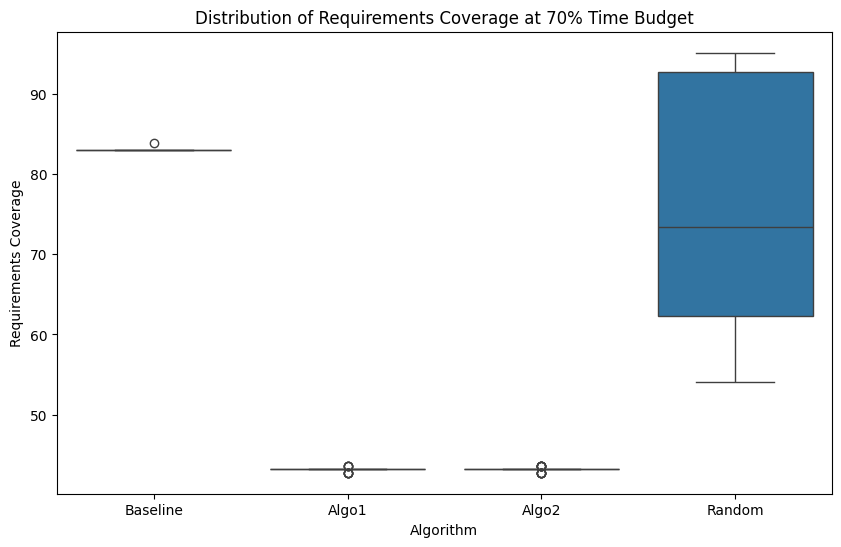


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   83.091398   0.147237
Algo1      43.131720   0.224215
Algo2      43.158602   0.269627
Random     75.672043  15.158632

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 233.2221
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +39.9597 [34.8569, 45.0625]  0.0000          Yes
  Algo1 vs Random  +32.5403 [27.4375, 37.6431]  0.0000          Yes
Algo2 vs Baseline  +39.9328 [34.8300, 45.0356]  0.0000          Yes
  Algo2 vs Random  +32.5134 [27.4107, 37.6162]  0.0000          Yes
   Algo1 vs Algo2   +0.0269  [-5.0759, 5.1297]  1.0000           No

ANALYSIS FOR: Time Budget = 75%, Output = Business Value


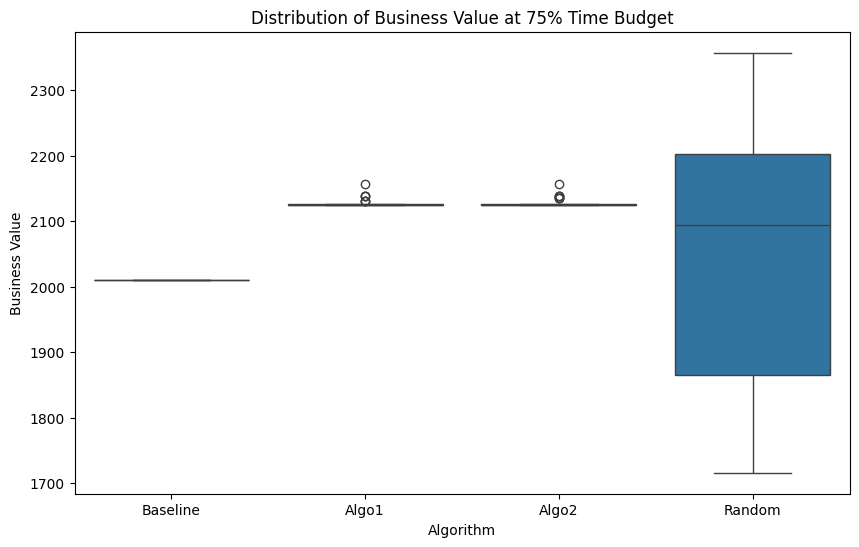


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   2010.000000    0.000000
Algo1      2128.000000    6.873236
Algo2      2128.466667    7.224161
Random     2051.133333  205.589603

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 9.8048
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline -118.0000 [-187.2661, -48.7339]  0.0001          Yes
  Algo1 vs Random  -76.8667  [-146.1328, -7.6005]  0.0233          Yes
Algo2 vs Baseline -118.4667 [-187.7328, -49.2005]  0.0001          Yes
  Algo2 vs Random  -77.3333  [-146.5995, -8.0672]  0.0222          Yes
   Algo1 vs Algo2   +0.4667   [-68.7995, 69.7328]  1.0000           No

ANALYSIS FOR: Time Budget = 75%, Output = Requirements Coverage


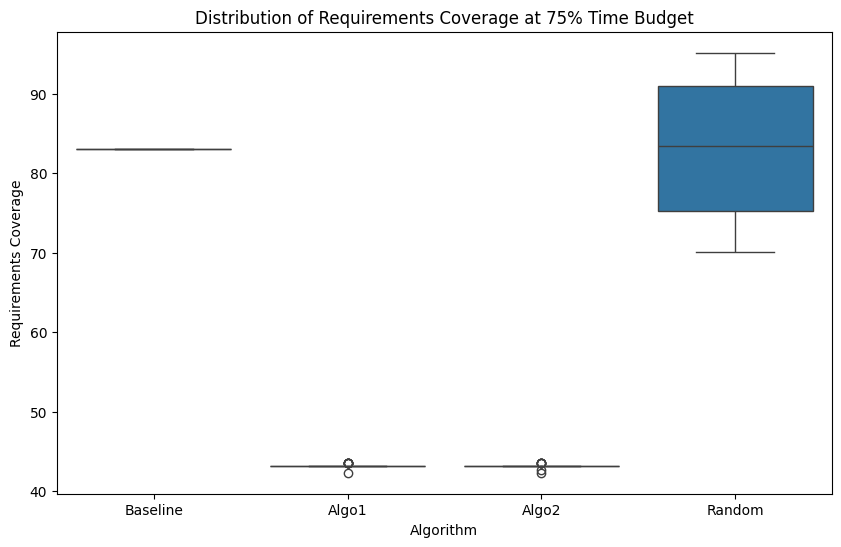


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   83.064516  0.000000
Algo1      43.212366  0.238747
Algo2      43.185484  0.244930
Random     82.768817  8.769220

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 819.3305
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +39.8522 [36.8989, 42.8054]  0.0000          Yes
  Algo1 vs Random  +39.5565 [36.6032, 42.5097]  0.0000          Yes
Algo2 vs Baseline  +39.8790 [36.9258, 42.8323]  0.0000          Yes
  Algo2 vs Random  +39.5833 [36.6301, 42.5366]  0.0000          Yes
   Algo1 vs Algo2   -0.0269  [-2.9801, 2.9264]  1.0000           No

ANALYSIS FOR: Time Budget = 80%, Output = Business Value


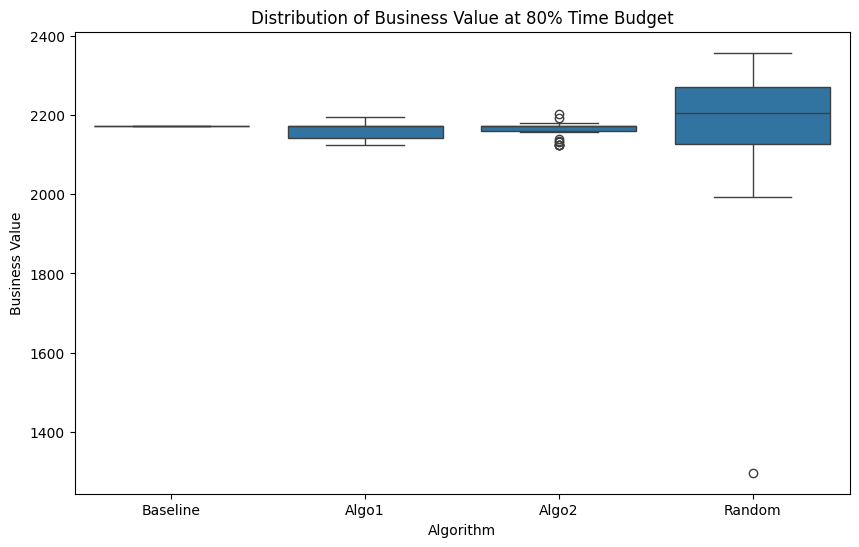


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   2171.000000    0.000000
Algo1      2158.966667   20.863238
Algo2      2162.700000   20.484056
Random     2173.833333  188.200935

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 0.1601
p-value: 0.9230

Result: No significant difference among algorithms.

ANALYSIS FOR: Time Budget = 80%, Output = Requirements Coverage


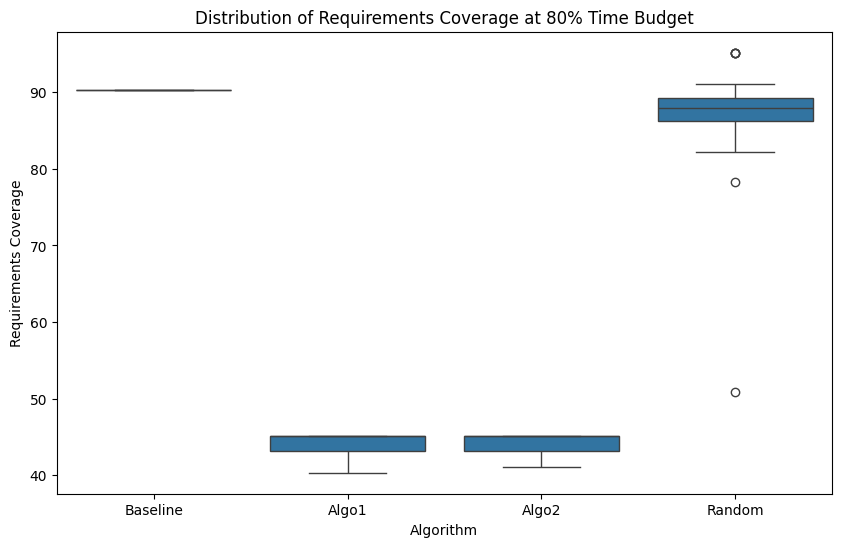


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   90.322581  0.000000
Algo1      44.045699  1.411522
Algo2      44.193548  1.370886
Random     86.854839  7.804915

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 1224.6158
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +46.2769 [43.5682, 48.9856]  0.0000          Yes
  Algo1 vs Random  +42.8091 [40.1005, 45.5178]  0.0000          Yes
Algo2 vs Baseline  +46.1290 [43.4203, 48.8377]  0.0000          Yes
  Algo2 vs Random  +42.6613 [39.9526, 45.3700]  0.0000          Yes
   Algo1 vs Algo2   +0.1478  [-2.5608, 2.8565]  0.9990           No

ANALYSIS FOR: Time Budget = 85%, Output = Business Value


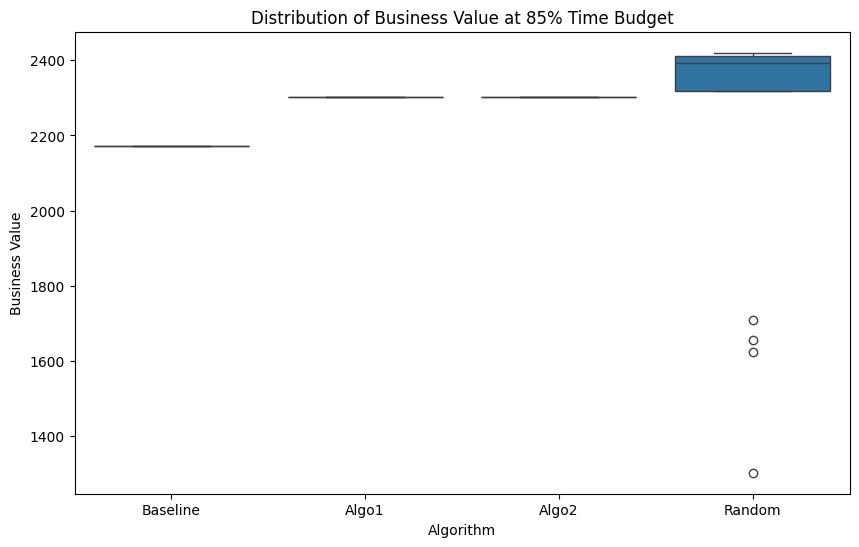


--- Descriptive Statistics ---
                  mean        std
algorithm                        
Baseline   2171.000000    0.00000
Algo1      2302.000000    0.00000
Algo2      2302.000000    0.00000
Random     2269.866667  286.95605

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 5.6060
p-value: 0.0013

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline -131.0000 [-227.5662, -34.4338]  0.0032          Yes
  Algo1 vs Random  -32.1333  [-128.6995, 64.4328]  0.8216           No
Algo2 vs Baseline -131.0000 [-227.5662, -34.4338]  0.0032          Yes
  Algo2 vs Random  -32.1333  [-128.6995, 64.4328]  0.8216           No
   Algo1 vs Algo2   +0.0000   [-96.5662, 96.5662]  1.0000           No

ANALYSIS FOR: Time Budget = 85%, Output = Requirements Coverage


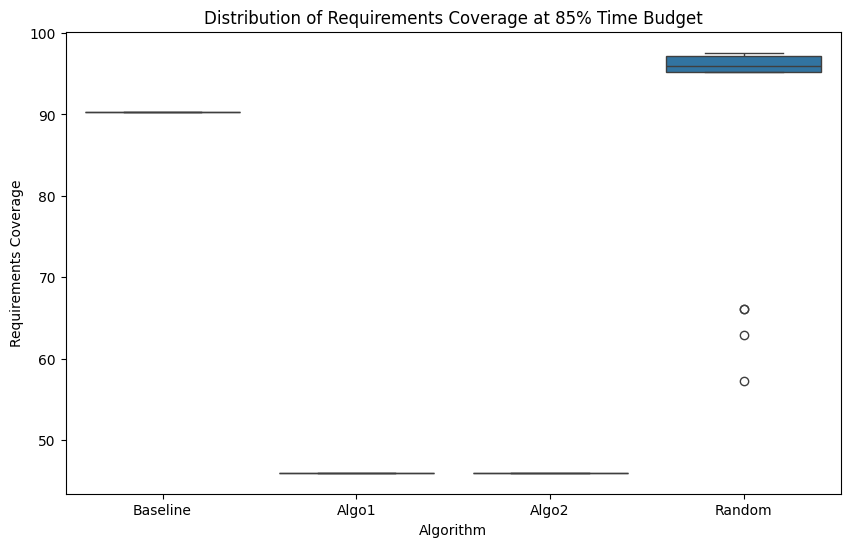


--- Descriptive Statistics ---
                mean        std
algorithm                      
Baseline   90.322581   0.000000
Algo1      45.967742   0.000000
Algo2      45.967742   0.000000
Random     91.801075  11.563289

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 608.6530
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +44.3548 [40.4636, 48.2461]  0.0000          Yes
  Algo1 vs Random  +45.8333 [41.9421, 49.7246]  0.0000          Yes
Algo2 vs Baseline  +44.3548 [40.4636, 48.2461]  0.0000          Yes
  Algo2 vs Random  +45.8333 [41.9421, 49.7246]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-3.8913, 3.8913]  1.0000           No

ANALYSIS FOR: Time Budget = 90%, Output = Business Value


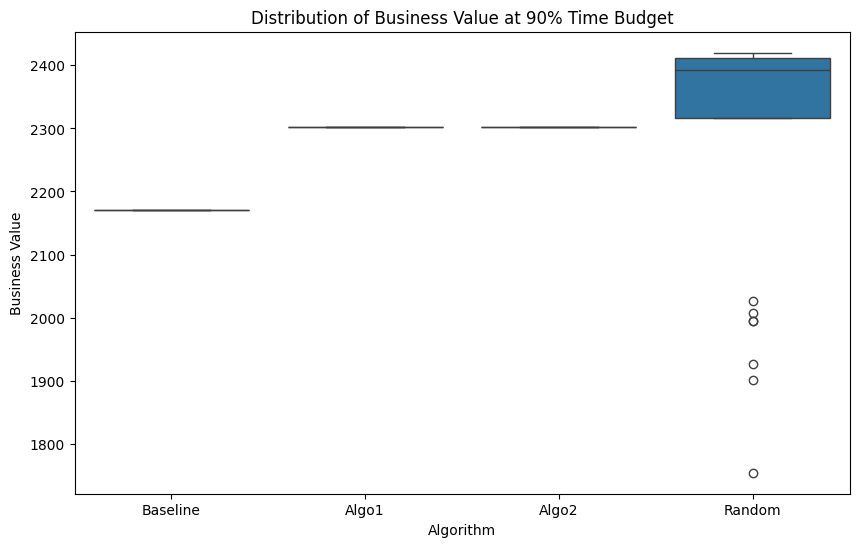


--- Descriptive Statistics ---
                  mean         std
algorithm                         
Baseline   2171.000000    0.000000
Algo1      2302.000000    0.000000
Algo2      2302.000000    0.000000
Random     2277.466667  196.052902

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 12.1917
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline -131.0000 [-196.9755, -65.0245]  0.0000          Yes
  Algo1 vs Random  -24.5333   [-90.5089, 41.4422]  0.7671           No
Algo2 vs Baseline -131.0000 [-196.9755, -65.0245]  0.0000          Yes
  Algo2 vs Random  -24.5333   [-90.5089, 41.4422]  0.7671           No
   Algo1 vs Algo2   +0.0000   [-65.9755, 65.9755]  1.0000           No

ANALYSIS FOR: Time Budget = 90%, Output = Requirements Coverage


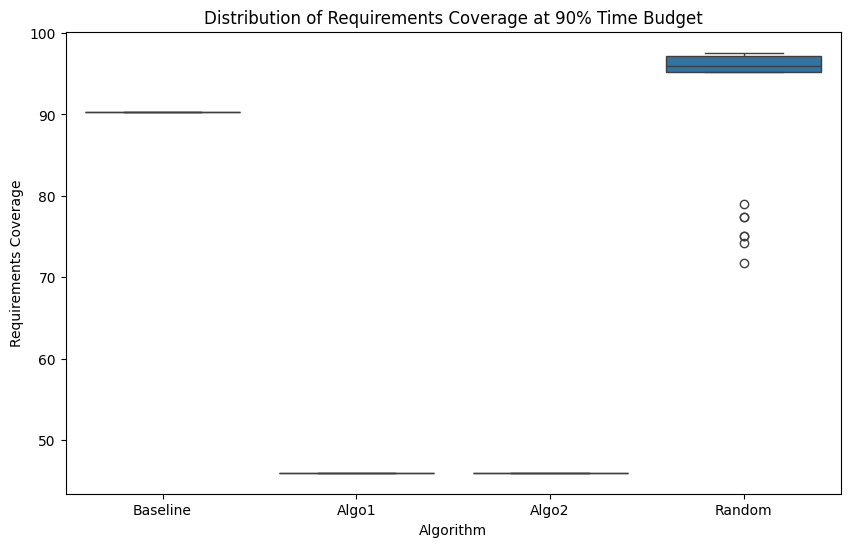


--- Descriptive Statistics ---
                mean       std
algorithm                     
Baseline   90.322581  0.000000
Algo1      45.967742  0.000000
Algo2      45.967742  0.000000
Random     91.478495  8.971979

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 1003.5849
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +44.3548 [41.3356, 47.3741]  0.0000          Yes
  Algo1 vs Random  +45.5108 [42.4915, 48.5300]  0.0000          Yes
Algo2 vs Baseline  +44.3548 [41.3356, 47.3741]  0.0000          Yes
  Algo2 vs Random  +45.5108 [42.4915, 48.5300]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-3.0192, 3.0192]  1.0000           No

ANALYSIS FOR: Time Budget = 95%, Output = Business Value


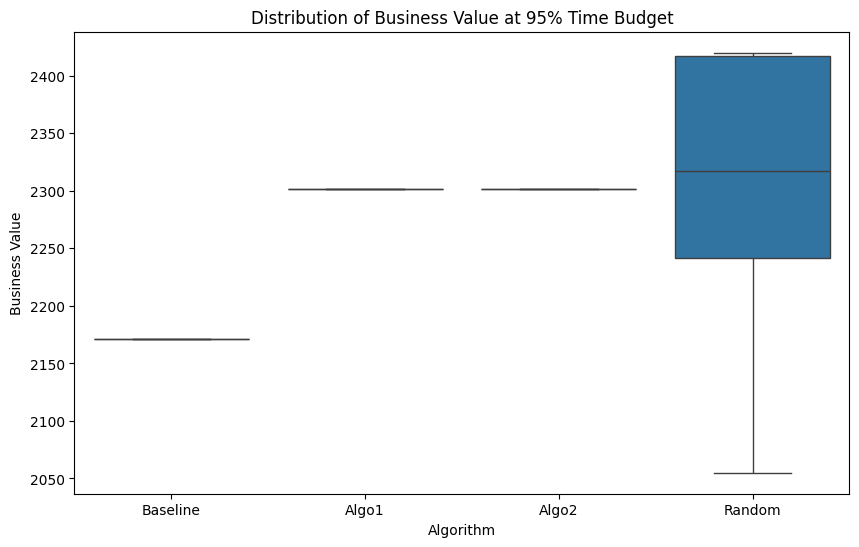


--- Descriptive Statistics ---
             mean         std
algorithm                    
Baseline   2171.0    0.000000
Algo1      2302.0    0.000000
Algo2      2302.0    0.000000
Random     2312.8  111.878752

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 43.6711
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff                95% CI p-value Significant?
Algo1 vs Baseline -131.0000 [-168.6493, -93.3507]  0.0000          Yes
  Algo1 vs Random  +10.8000   [-26.8493, 48.4493]  0.8775           No
Algo2 vs Baseline -131.0000 [-168.6493, -93.3507]  0.0000          Yes
  Algo2 vs Random  +10.8000   [-26.8493, 48.4493]  0.8775           No
   Algo1 vs Algo2   +0.0000   [-37.6493, 37.6493]  1.0000           No

ANALYSIS FOR: Time Budget = 95%, Output = Requirements Coverage


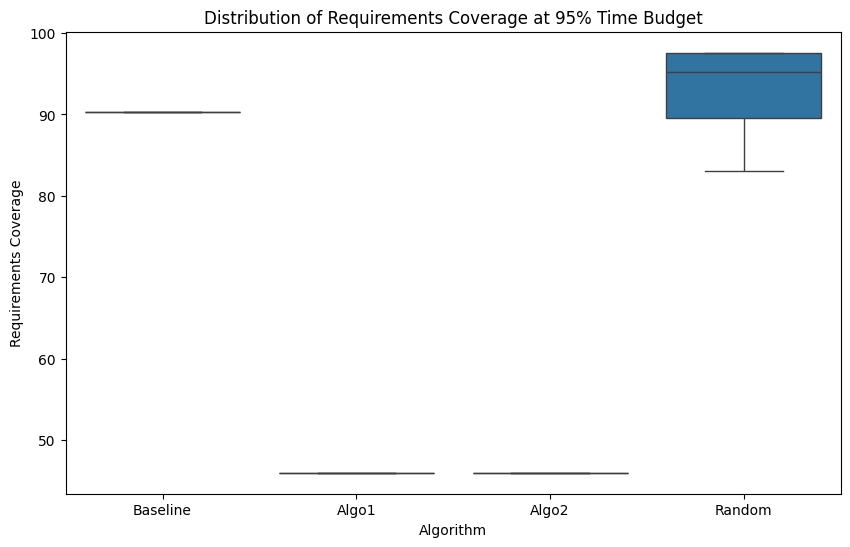


--- Descriptive Statistics ---
                mean      std
algorithm                    
Baseline   90.322581  0.00000
Algo1      45.967742  0.00000
Algo2      45.967742  0.00000
Random     93.172043  4.71064

--- Overall Comparison (One-way ANOVA) ---
F-statistic: 3785.1585
p-value: 0.0000

Result: Significant difference detected. Proceeding to pairwise tests.

--- Pairwise Comparisons (Tukey HSD) ---
             Pair Mean diff             95% CI p-value Significant?
Algo1 vs Baseline  +44.3548 [42.7696, 45.9401]  0.0000          Yes
  Algo1 vs Random  +47.2043 [45.6191, 48.7895]  0.0000          Yes
Algo2 vs Baseline  +44.3548 [42.7696, 45.9401]  0.0000          Yes
  Algo2 vs Random  +47.2043 [45.6191, 48.7895]  0.0000          Yes
   Algo1 vs Algo2   +0.0000  [-1.5852, 1.5852]  1.0000           No


In [ ]:
# ======================================================
# Cell 3: Steps 2 & 3 - Budget-by-Budget Analysis
# ======================================================

if 'tidy_df' in locals():

    ALGO_NAMES = ['Baseline', 'Algo1', 'Algo2', 'Random']
    OUTPUT_METRICS = {'OP1_BV': 'Business Value', 'OP2_reqcvg': 'Requirements Coverage'}
    PAIRS_TO_COMPARE = [
        ('Algo1', 'Baseline'), ('Algo1', 'Random'),
        ('Algo2', 'Baseline'), ('Algo2', 'Random'),
        ('Algo1', 'Algo2')
    ]

    for budget in sorted(tidy_df['time_budget'].unique()):
        for metric_col, metric_name in OUTPUT_METRICS.items():

            print("\n" + "="*80)
            print(f"ANALYSIS FOR: Time Budget = {budget}%, Output = {metric_name}")
            print("="*80)

            budget_df = tidy_df[tidy_df['time_budget'] == budget]

            plt.figure(figsize=(10, 6))
            sns.boxplot(x='algorithm', y=metric_col, data=budget_df, order=ALGO_NAMES)
            plt.title(f'Distribution of {metric_name} at {budget}% Time Budget')
            plt.ylabel(metric_name); plt.xlabel('Algorithm'); plt.show()

            print("\n--- Descriptive Statistics ---")
            stats_summary = budget_df.groupby('algorithm')[metric_col].agg(['mean', 'std']).loc[ALGO_NAMES]
            print(stats_summary)

            grouped_data = [budget_df[budget_df['algorithm'] == algo][metric_col].dropna().values for algo in ALGO_NAMES]
            if any(len(d) < 2 for d in grouped_data):
                print("\nWarning: Not enough data for ANOVA. Skipping.")
                continue

            f_stat, p_value = f_oneway(*grouped_data)

            print("\n--- Overall Comparison (One-way ANOVA) ---")
            print(f"F-statistic: {f_stat:.4f}"); print(f"p-value: {p_value:.4f}")

            if p_value >= 0.05:
                print("\nResult: No significant difference among algorithms.")
                continue
            else:
                print("\nResult: Significant difference detected. Proceeding to pairwise tests.")

            tukey_result = pairwise_tukeyhsd(endog=budget_df[metric_col].dropna(), groups=budget_df['algorithm'].dropna(), alpha=0.05)
            results_table = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

            pairwise_results = []
            for group1, group2 in PAIRS_TO_COMPARE:
                res = results_table[((results_table['group1'] == group1) & (results_table['group2'] == group2)) | ((results_table['group1'] == group2) & (results_table['group2'] == group1))]
                if not res.empty:
                    res_row = res.iloc[0]; mean_diff = res_row['meandiff']
                    if res_row['group1'] != group1: mean_diff = -mean_diff
                    pairwise_results.append({
                        'Pair': f"{group1} vs {group2}", 'Mean diff': f"{mean_diff:+.4f}",
                        '95% CI': f"[{res_row['lower']:.4f}, {res_row['upper']:.4f}]",
                        'p-value': f"{res_row['p-adj']:.4f}", 'Significant?': "Yes" if res_row['reject'] else "No"
                    })

            print("\n--- Pairwise Comparisons (Tukey HSD) ---")
            if pairwise_results: print(pd.DataFrame(pairwise_results).to_string(index=False))
            else: print("Could not find specified pairs in the Tukey HSD results.")
else:
    print("Tidy data not found. Please run Cell 2 to compile the data first.")

In [ ]:
# ======================================================
# Cell 4: Generate Comprehensive Excel Report
# ======================================================

if 'tidy_df' in locals():
    output_excel_filename = "Full_Statistical_Analysis_Report.xlsx"
    print(f"\n\n" + "="*80)
    print(f"--- Generating Comprehensive Excel Report: '{output_excel_filename}' ---")
    print("This may take a moment...")

    with pd.ExcelWriter(output_excel_filename, engine='openpyxl') as writer:
        tidy_df.to_excel(writer, sheet_name='Tidy_Raw_Data', index=False)

        ALGO_NAMES = ['Baseline', 'Algo1', 'Algo2', 'Random']
        OUTPUT_METRICS = {'OP1_BV': 'Business Value', 'OP2_reqcvg': 'Requirements Coverage'}
        PAIRS_TO_COMPARE = [
            ('Algo1', 'Baseline'), ('Algo1', 'Random'),
            ('Algo2', 'Baseline'), ('Algo2', 'Random'),
            ('Algo1', 'Algo2')
        ]

        for budget in sorted(tidy_df['time_budget'].unique()):
            for metric_col, metric_name in OUTPUT_METRICS.items():
                sheet_name = f"{metric_name.replace(' ', '')}_at_{budget}pct"
                budget_df = tidy_df[tidy_df['time_budget'] == budget]
                ws = writer.book.create_sheet(title=sheet_name)

                stats_summary = budget_df.groupby('algorithm')[metric_col].agg(['mean', 'std']).loc[ALGO_NAMES]
                stats_summary.to_excel(writer, sheet_name=sheet_name, startrow=1, startcol=1)
                ws['B1'] = "Descriptive Statistics"

                fig, ax = plt.subplots(figsize=(8, 5))
                sns.boxplot(ax=ax, x='algorithm', y=metric_col, data=budget_df, order=ALGO_NAMES)
                ax.set_title(f'Distribution of {metric_name} at {budget}% Budget')
                img_buffer = BytesIO()
                fig.savefig(img_buffer, format='png', bbox_inches='tight'); plt.close(fig)
                img = OpenpyxlImage(img_buffer); img.anchor = 'H2'; ws.add_image(img)

                grouped_data = [budget_df[budget_df['algorithm'] == algo][metric_col].dropna().values for algo in ALGO_NAMES]
                if any(len(d) < 2 for d in grouped_data): continue
                f_stat, p_value = f_oneway(*grouped_data)

                ws['B8'] = "Overall Comparison (One-way ANOVA)"
                ws['B9'] = "F-statistic"; ws['C9'] = f_stat
                ws['B10'] = "p-value"; ws['C10'] = p_value
                ws['B11'] = "Result:"; ws['C11'] = "Significant difference detected" if p_value < 0.05 else "No significant difference"

                if p_value < 0.05:
                    tukey_result = pairwise_tukeyhsd(endog=budget_df[metric_col].dropna(), groups=budget_df['algorithm'].dropna(), alpha=0.05)
                    results_table = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

                    pairwise_results = []
                    for group1, group2 in PAIRS_TO_COMPARE:
                        res = results_table[((results_table['group1'] == group1) & (results_table['group2'] == group2)) | ((results_table['group1'] == group2) & (results_table['group2'] == group1))]
                        if not res.empty:
                            res_row = res.iloc[0]; mean_diff = res_row['meandiff']
                            if res_row['group1'] != group1: mean_diff = -mean_diff
                            pairwise_results.append({'Pair': f"{group1} vs {group2}", 'Mean diff': f"{mean_diff:+.4f}", '95% CI': f"[{res_row['lower']:.4f}, {res_row['upper']:.4f}]", 'p-value': f"{res_row['p-adj']:.4f}", 'Significant?': "Yes" if res_row['reject'] else "No"})

                    if pairwise_results:
                        tukey_df = pd.DataFrame(pairwise_results)
                        tukey_df.to_excel(writer, sheet_name=sheet_name, startrow=13, startcol=1, index=False)
                        ws['B13'] = "Pairwise Comparisons (Tukey HSD)"

    print(f"\n--- Report generation complete. ---")
    print(f"All analyses saved to '{output_excel_filename}'. You can now download it.")
    files.download(output_excel_filename)
else:
    print("Tidy data not found. Please run Cell 2 to compile the data first.")



--- Generating Comprehensive Excel Report: 'Full_Statistical_Analysis_Report.xlsx' ---
This may take a moment...

--- Report generation complete. ---
All analyses saved to 'Full_Statistical_Analysis_Report.xlsx'. You can now download it.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>